# Pothole detection

*Jacek Piszczek 227081*

*Damodar Łepski 227122*

*__Introduction to Computer Vision PWR Course__*


In [1]:
ROAD_IMAGE_DATA_FOLDER = 'Road_Image_Data'
POTHOLE_IMAGE_DATA_FOLDER = 'Pothole_Image_Data'

### Prepare image names from folders

Pothole images are downloaded from public repository [1]. Nice road images are found in Google Graphic [2].

In [2]:
from subprocess import check_output

def get_image_list(folder_name):
    images = check_output(['ls', folder_name]).decode('utf-8').split('\n')
    return list(filter(None, images))


nice_road_images = get_image_list(ROAD_IMAGE_DATA_FOLDER)
pothole_images = get_image_list(POTHOLE_IMAGE_DATA_FOLDER)

### Scale and HOG images

This function below takes each image from given folder and:

- resize it to 640x480 resolution, to make sure each image has the same dimension. That allows to gain the same amount of features.
- calculate Histogram of Oriented Gradients with 8 orientations and group areas 8x8.
- rescale intensity of image to better show the edges.

The result of this function is an image set and feature set of given dataset.

In [4]:

import pandas as pd
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread
from skimage.transform import resize


def scale_and_hog(folder_name, image_names):
    images_list = []
    features_list = []
    for img_name in image_names:
        image = imread('{}/{}'.format(folder_name, img_name))
        image = resize(image, (480, 640))
        try:
            fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, multichannel=True)

            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 5))
            images_list.append(hog_image_rescaled)
            features_list.append(fd)
        except:
            print('Error: {}'.format(img_name))
    print("{} done!".format(ROAD_IMAGE_DATA_FOLDER))
    return features_list, images_list

### Scale and HOG nice road

In [5]:
nice_fd, nice_img = scale_and_hog(ROAD_IMAGE_DATA_FOLDER, nice_road_images)

Road_Image_Data done!


### Scale and HOG Potholes

In [6]:
pothole_fd, pothole_img = scale_and_hog(POTHOLE_IMAGE_DATA_FOLDER, pothole_images)

Error: 5.jpg
Road_Image_Data done!


### Sample images after hog conversion

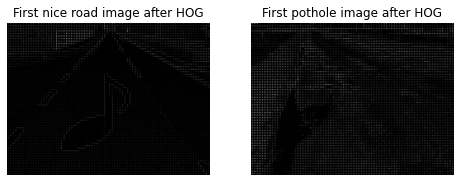

In [53]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(nice_img[0], cmap=plt.cm.gray)
ax1.set_title('First nice road image after HOG')

ax2.axis('off')
ax2.imshow(pothole_img[0], cmap=plt.cm.gray)
ax2.set_title('First pothole image after HOG')
plt.show()

### Create labels and merge to one datasets

Images are preprocessed, now is time to label it. It will be binary classification:
- 0 for nice road images,
- 1 for detected image with potholes.

In [87]:
nice_labels = [0 for _ in range(len(nice_fd))]
pothole_labels = [1 for _ in range(len(pothole_fd))]
print('Labels for nice roads: {}'.format(len(nice_labels)))
print('Labels for potholes: {}'.format(len(pothole_labels)))

dataset_X = nice_fd + pothole_fd
dataset_y = nice_labels + pothole_labels

# Test image labeling
# 0-49 should be images of nice roads (0)
# Above are potholes (1)
no = 55
print('******************')
print(dataset_X[no], dataset_y[no])


Labels for nice roads: 50
Labels for potholes: 148
******************
[0.24372526 0.         0.49460775 ... 0.04441135 0.22166617 0.16697653] 1


### Prepare data frame

In [91]:
import numpy as np

labels =  np.array(dataset_y).reshape(len(dataset_y), 1)
dataset_X = np.array(dataset_X)
data_frame = np.hstack((dataset_X, labels))

np.random.shuffle(data_frame)
print(data_frame)

[[0.35355339 0.35355339 0.35355339 ... 0.35090801 0.10325073 1.        ]
 [0.43735674 0.43735674 0.43735674 ... 0.43868187 0.25060828 0.        ]
 [0.18896023 0.         0.03454771 ... 0.09574922 0.45350024 1.        ]
 ...
 [0.38614648 0.38614648 0.38614648 ... 0.38621407 0.38621407 1.        ]
 [0.41034526 0.         0.         ... 0.38044724 0.38044724 1.        ]
 [0.35524244 0.1215957  0.1468416  ... 0.3810206  0.3810206  1.        ]]


### Divide data to train and test and fit classifiers

We got three classifiers for carry out the study.
- Support Vector Classifier capable of performing multi-class classification on a dataset[3].
- Gaussian Naive Bayes implements the Gaussian Naive Bayes algorithm for classification[3].
- Stochastic Gradiend Classifier implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties for classification[3].

In [92]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

train_percent = 50
p = int(len(dataset_X)*train_percent/100)

x_train, x_test = data_frame[:p,:-1],  data_frame[p:,:-1]
y_train, y_test = data_frame[:p,-1:].ravel() , data_frame[p:,-1:].ravel()

clfs = {
    'SVC': svm.SVC(),
    'GNB': GaussianNB(),
    'SGD': SGDClassifier(loss="hinge", penalty="l2")
}

for name, clf in clfs.items():
    print('Fitting {}...'.format(name))
    clf.fit(x_train, y_train)
print('Done.')

Fitting SVC...
Fitting GNB...
Fitting SGD...
Done.


### __Run prediction of SVC Classifier__

In [93]:
from sklearn.metrics import classification_report, accuracy_score

prediction_results = {}
for name, clf in clfs.items():
    prediction_results[name] = clf.predict(x_test)

# print('Prediction results:')
# print(prediction_results)

for name, y_pred in prediction_results.items():
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy for {}: {}'.format(name, acc))

# print('\n')
# print(classification_report(y_test, y_pred))

Accuracy for SVC: 0.7575757575757576
Accuracy for GNB: 0.8080808080808081
Accuracy for SGD: 0.797979797979798


Done.

### References:
    
    [1] https://www.kaggle.com/sachinpatel21/pothole-image-dataset/data
    [2] https://www.google.pl/imghp
    [3] https://scikit-learn.org/